In [16]:
import tensorflow as tf
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras import layers,losses

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset =raw_dataset.copy()

dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [17]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [18]:
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [19]:
origin = dataset.pop("Origin")
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [20]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [21]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [22]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [23]:
# 标准化数据
def norm(x):
    # 标准差标准化
    return (x-train_stats["mean"])/train_stats['std']

In [24]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data)
print(normed_test_data)

     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   
..         ...           ...         ...       ...           ...         ...   
281   0.307270      0.044872   -0.521559 -0.000298      0.946772    0.843910   
229   1.483887      1.961837    1.972127  1.457223     -1.598734    0.299787   
150  -0.869348     -0.836932   -0.311564 -0.710099     -0.021237   -0.516397   
145  -0.869348     -1.076553   -1.151543 -1.169870      1.233589   -0.516397   
182  -0.869348     -0.846517   -0.495310 -0.623596     -0.021237    0.027726   

          USA    Europe     Japan  
146

In [25]:
train_db = tf.data.Dataset.from_tensor_slices((normed_train_data.values,train_labels.values))
train_db = train_db.shuffle(100).batch(32)

In [26]:
class Network(keras.Model):
    # 回归网络
    def __init__(self):
        super().__init__()
        self.fc1 = layers.Dense(64,activation='relu')
        self.fc2 = layers.Dense(64,activation='relu')
        self.fc3 = layers.Dense(1)

    def call(self,inputs,training = None,mask = None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [27]:
model = Network()
model.build(input_shape=(4,9))
print(model.summary())
optimizer = keras.optimizers.RMSprop(0.001)

Model: "network_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  640       
_________________________________________________________________
dense_4 (Dense)              multiple                  4160      
_________________________________________________________________
dense_5 (Dense)              multiple                  65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
loss_list1 = []
loss_list2 = []
for epoch in range(200):
    for step,(x,y) in enumerate(train_db):
        with tf.GradientTape() as tape:
            out = model(x)
            loss = tf.reduce_mean(losses.MSE(y,out))
            mae_loss = tf.reduce_mean(losses.MAE(y,out))
            
            if step % 10 ==0:
                loss_list1.append(loss)
                loss_list2.append(mae_loss)
                print(epoch,step,float(loss))

            # 跟新梯度
            grads = tape.gradient(target=loss,sources=model.trainable_variables)
            optimizer.apply_gradients(zip(grads,model.trainable_variables))

0 0 753.5888671875
1 0 554.1630859375
2 0 500.6622009277344
3 0 457.42822265625
4 0 316.8514404296875
5 0 279.21783447265625
6 0 229.71165466308594
7 0 157.70005798339844
8 0 163.16009521484375
9 0 125.22576141357422
10 0 70.02790832519531
11 0 70.96701049804688
12 0 91.25007629394531
13 0 65.63526916503906
14 0 74.70967864990234
15 0 82.88861083984375
16 0 79.1527099609375
17 0 87.32650756835938
18 0 88.6084213256836
19 0 49.680686950683594
20 0 56.787010192871094
21 0 48.838539123535156
22 0 78.45997619628906
23 0 61.36513900756836
24 0 59.82392883300781
25 0 67.68736267089844
26 0 71.12120819091797
27 0 40.48199462890625
28 0 51.39344024658203
29 0 65.47648620605469
30 0 52.51606750488281
31 0 69.01856994628906
32 0 60.155616760253906
33 0 59.070552825927734
34 0 63.62898254394531
35 0 64.75371551513672
36 0 76.92405700683594
37 0 75.34886169433594
38 0 51.61963653564453
39 0 62.6343994140625
40 0 75.283203125
41 0 71.09419250488281
42 0 83.80290985107422
43 0 75.86196899414062
44 0

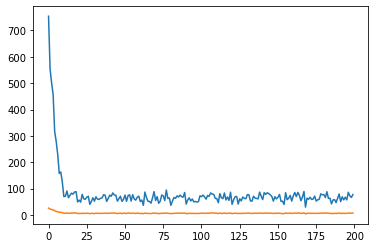

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(200),loss_list1,range(200),loss_list2)
plt.show()